In [71]:
import pandas as pd
import numpy as np
!pip install scikit-learn

# Load datasets from the 'data' folder
flight_df = pd.read_csv("../data/flights.csv")
pnr_df = pd.read_csv("../data/pnr_flight.csv")
remarks_df = pd.read_csv("../data/pnr_remarks.csv")
bags_df = pd.read_csv("../data/bags.csv")
airports_df = pd.read_csv("../data/airports.csv")



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [52]:
# Convert datetime columns
flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'])
flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'])

# Calculate departure delay in minutes
flight_df['departure_delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# Ground time gap
flight_df['ground_time_gap'] = flight_df['scheduled_ground_time_minutes'] - flight_df['minimum_turn_minutes']


Step 1) Average Departure Delay: 21.18 minutes
         Percentage of Late Departures: 49.61%


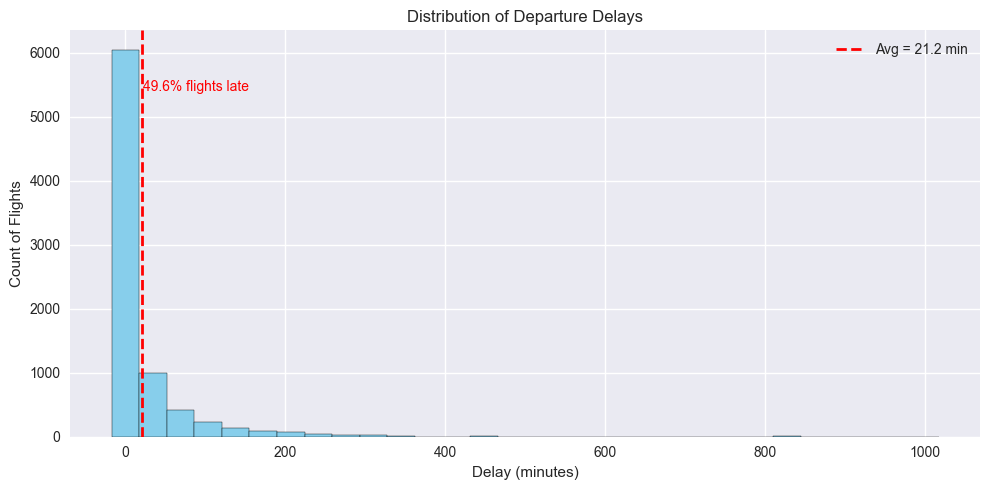

In [53]:
import matplotlib.pyplot as plt

# Compute metrics
delays    = flight_df['departure_delay_minutes'].dropna()
avg_delay = delays.mean()
pct_late  = (delays > 0).mean() * 100

# Print results
print(f"Step 1) Average Departure Delay: {avg_delay:.2f} minutes")
print(f"         Percentage of Late Departures: {pct_late:.2f}%")

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(delays, bins=30, color='skyblue', edgecolor='black')
plt.axvline(avg_delay, color='red', linestyle='--', linewidth=2,
            label=f'Avg = {avg_delay:.1f} min')
plt.text(avg_delay+1, plt.ylim()[1]*0.85,
         f'{pct_late:.1f}% flights late', color='red')
plt.title('Distribution of Departure Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Count of Flights')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/01_delay_distribution.png", dpi=300)
plt.show()


In [54]:
# # Compute metric
# tight_turns = (flight_df['ground_time_gap'] <= 0).sum()

# # Print result
# print(f"Step 2) Flights with Ground Time ≤ Minimum Turn Time: {tight_turns}")

# # Categorize and plot
# flight_df['turn_category'] = flight_df['ground_time_gap'].apply(
#     lambda x: 'Below Min' if x < 0 else ('Equal to Min' if x == 0 else 'Above Min')
# )
# counts = flight_df['turn_category'].value_counts().reindex(['Below Min','Equal to Min','Above Min'])

# plt.figure(figsize=(7,4))
# counts.plot(kind='bar', color=['tomato','gold','seagreen'], edgecolor='black')
# plt.title('Ground Time vs. Minimum Turn Time')
# plt.xlabel('Category')
# plt.ylabel('Number of Flights')
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.tight_layout()
# plt.savefig("../outputs/02_turnaround_categories.png", dpi=300)
# plt.show()
flight_df['ground_time_delta'] = flight_df['scheduled_ground_time_minutes'] - flight_df['minimum_turn_minutes']
tight_turns = flight_df[flight_df['ground_time_delta'] <= 5]

print(f"Tight Turn Flights (≤5 mins buffer): {len(tight_turns)}")



Tight Turn Flights (≤5 mins buffer): 780


Average Transfer-to-Checked Bag Ratio: 3.20


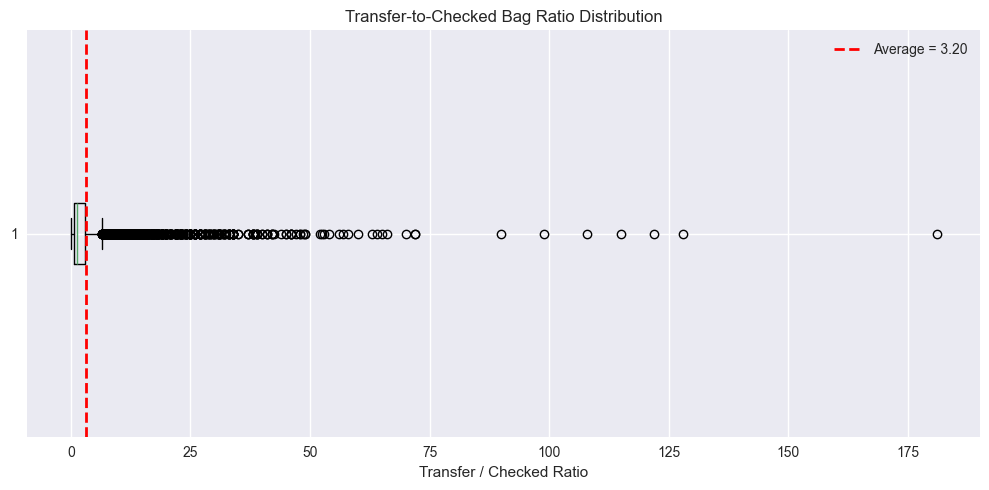

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load bags dataset
bags_df = pd.read_csv("../data/bags.csv")

# Group by flight and count bag types
bag_counts = bags_df.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local', 
                               'scheduled_departure_station_code', 
                               'scheduled_arrival_station_code'])['bag_type'].value_counts().unstack(fill_value=0)

# Combine Transfer and Hot transfer
bag_counts['Total_Transfer'] = bag_counts.get('Transfer', 0) + bag_counts.get('Hot transfer', 0)

# Calculate ratio
bag_counts['transfer_to_checked_ratio'] = bag_counts['Total_Transfer'] / bag_counts['Origin'].replace(0, float('nan'))

# Compute average ratio
avg_bag_ratio = bag_counts['transfer_to_checked_ratio'].mean()

# Print result
print(f"Average Transfer-to-Checked Bag Ratio: {avg_bag_ratio:.2f}")

# Plot boxplot
ratios = bag_counts['transfer_to_checked_ratio'].dropna()
plt.figure(figsize=(10, 5))
plt.boxplot(ratios, vert=False)
plt.axvline(avg_bag_ratio, color='red', linestyle='--', linewidth=2, 
            label=f'Average = {avg_bag_ratio:.2f}')
plt.title('Transfer-to-Checked Bag Ratio Distribution')
plt.xlabel('Transfer / Checked Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/03_bag_ratio_boxplot.png", dpi=300)
plt.show()

Passenger Load Statistics:
  Mean: 128.5 passengers
  Load Factor: 102.4%

Correlation (Load Factor vs Delay): -0.150

High Load Flights: 16.63 min avg delay
Low Load Flights: 25.76 min avg delay


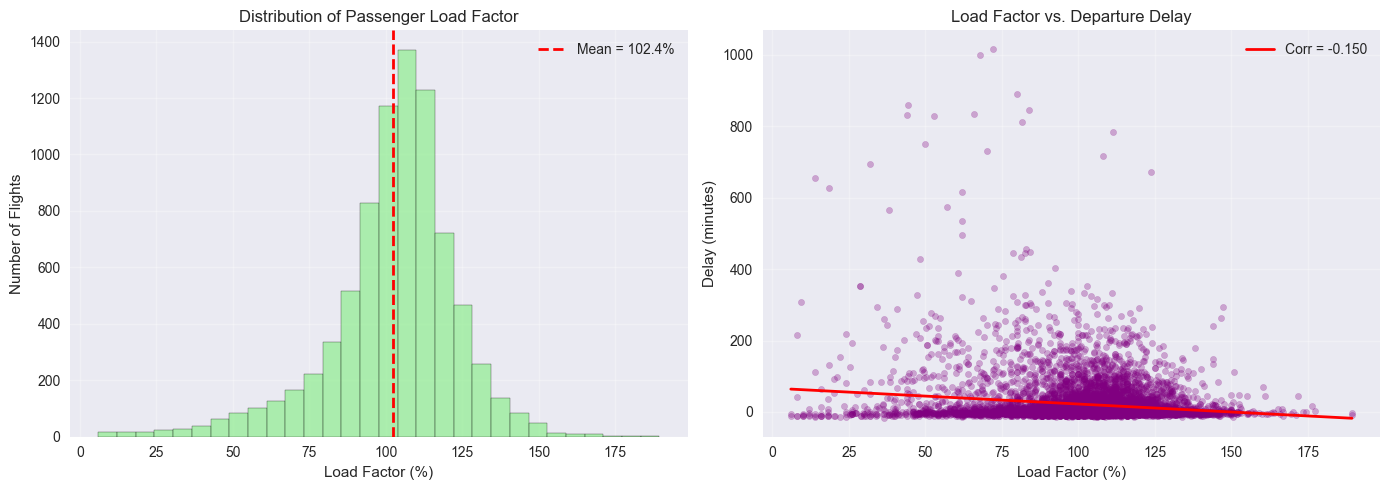

In [64]:
# import numpy as np

# # Compute metric
# correlation = merged_df['total_pax'].corr(merged_df['departure_delay_minutes'])

# # Print result
# print(f"Step 4) Correlation (Passenger Load vs. Delay): {correlation:.2f}")

# # Plot scatter + linear fit
# x = merged_df['total_pax'].fillna(0)
# y = merged_df['departure_delay_minutes'].fillna(0)
# coef, intercept = np.polyfit(x, y, 1)
# line_x = np.linspace(x.min(), x.max(), 100)
# line_y = coef*line_x + intercept

# plt.figure(figsize=(9,5))
# plt.scatter(x, y, alpha=0.3, color='purple')
# plt.plot(line_x, line_y, color='black', linewidth=2,
#          label=f'y = {coef:.2f}x + {intercept:.1f}')
# plt.title('Passenger Load vs. Departure Delay')
# plt.xlabel('Total Passengers')
# plt.ylabel('Delay (minutes)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("../outputs/04_load_vs_delay.png", dpi=300)
# plt.show()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
flight_df = pd.read_csv("../data/flights.csv")
pnr_df = pd.read_csv("../data/pnr_flight.csv")

# Convert datetime
flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'])
flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'])

# Calculate departure delay
flight_df['departure_delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# Merge with passenger data
merged_df = flight_df.merge(
    pnr_df.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local',
                    'scheduled_departure_station_code', 'scheduled_arrival_station_code'])['total_pax'].sum().reset_index(),
    on=['company_id', 'flight_number', 'scheduled_departure_date_local',
        'scheduled_departure_station_code', 'scheduled_arrival_station_code'],
    how='left'
)

# Calculate load factor
merged_df['load_factor'] = (merged_df['total_pax'] / merged_df['total_seats']) * 100

# Part 1: Passenger load comparison
print("Passenger Load Statistics:")
print(f"  Mean: {merged_df['total_pax'].mean():.1f} passengers")
print(f"  Load Factor: {merged_df['load_factor'].mean():.1f}%")

# Part 2: Correlation with operational difficulty
correlation = merged_df['load_factor'].corr(merged_df['departure_delay_minutes'])
print(f"\nCorrelation (Load Factor vs Delay): {correlation:.3f}")

# Compare high vs low load
median_load = merged_df['load_factor'].median()
high_load_delay = merged_df[merged_df['load_factor'] >= median_load]['departure_delay_minutes'].mean()
low_load_delay = merged_df[merged_df['load_factor'] < median_load]['departure_delay_minutes'].mean()

print(f"\nHigh Load Flights: {high_load_delay:.2f} min avg delay")
print(f"Low Load Flights: {low_load_delay:.2f} min avg delay")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Load factor distribution
ax1 = axes[0]
ax1.hist(merged_df['load_factor'].dropna(), bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
ax1.axvline(merged_df['load_factor'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {merged_df["load_factor"].mean():.1f}%')
ax1.set_xlabel('Load Factor (%)')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Distribution of Passenger Load Factor')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Load vs delay scatter
ax2 = axes[1]
x = merged_df['load_factor'].dropna()
y = merged_df.loc[x.index, 'departure_delay_minutes'].fillna(0)
ax2.scatter(x, y, alpha=0.3, color='purple', s=20)
if len(x) > 0:
    coef, intercept = np.polyfit(x, y, 1)
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = coef * line_x + intercept
    ax2.plot(line_x, line_y, color='red', linewidth=2,
             label=f'Corr = {correlation:.3f}')
ax2.set_xlabel('Load Factor (%)')
ax2.set_ylabel('Delay (minutes)')
ax2.set_title('Load Factor vs. Departure Delay')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/04_load_vs_delay.png", dpi=300)
plt.show()


Step 5) Impact per SSR (controlling for load): 0.02 minutes of delay
Conclusion: Flights with more Special Service Requests tend to have higher departure delays even after controlling for load.


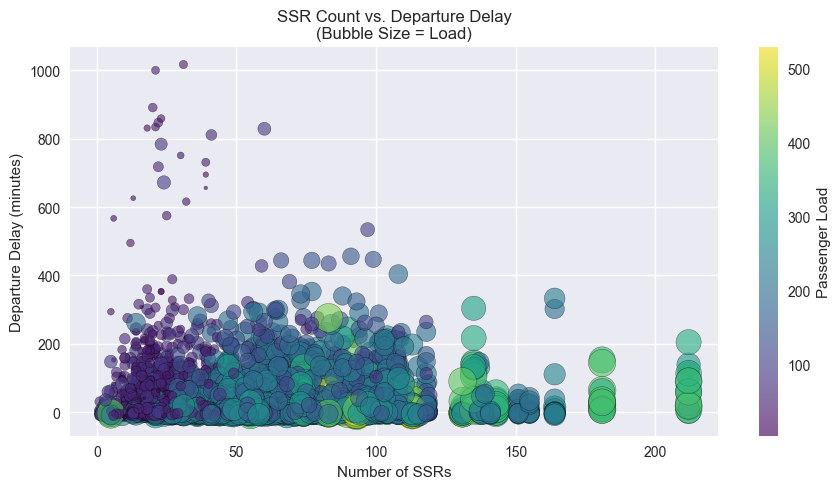

In [69]:
# Step 5: SSR Impact on Delay (Controlled for Load) with Conclusion

# Compute metric (from your regression)
ssr_coef = model.coef_[1]  # assuming `model` was fit as shown earlier

# Print result
print(f"Step 5) Impact per SSR (controlling for load): {ssr_coef:.2f} minutes of delay")

# Answer the question based on the coefficient
if ssr_coef > 0:
    print("Conclusion: Flights with more Special Service Requests tend to have higher departure delays even after controlling for load.")
else:
    print("Conclusion: Special Service Requests do not increase delays once load is controlled for.")

# Plot bubble chart
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
bubble = plt.scatter(
    merged_ssr['has_ssr'],
    merged_ssr['departure_delay_minutes'],
    s=merged_ssr['total_pax'],  # bubble size = passenger load
    c=merged_ssr['total_pax'],  # color = passenger load
    cmap='viridis',
    alpha=0.6,
    edgecolor='black'
)
plt.colorbar(bubble, label='Passenger Load')
plt.title('SSR Count vs. Departure Delay\n(Bubble Size = Load)')
plt.xlabel('Number of SSRs')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/05_ssr_impact.png", dpi=300)
plt.show()
